In [2]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

import pandas as pd
import numpy as np
import re
import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

STOPWORDS = set(stopwords.words('indonesian'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

NORMALIZATION_DICT = {
    'gak': 'tidak','ga': 'tidak','gk': 'tidak','ngga': 'tidak','nggak': 'tidak',
    'yg': 'yang','dgn': 'dengan','utk': 'untuk','pd': 'pada','krn': 'karena',
    'tdk': 'tidak','sdh': 'sudah','blm': 'belum','jg': 'juga','jd': 'jadi',
    'dll': 'dan lain lain'
}

def clean_text(text):
    if pd.isna(text): return ""
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def case_folding(text):
    return text.lower()

def normalize_text(text):
    words = text.split()
    normalized = [NORMALIZATION_DICT.get(w, w) for w in words]
    return " ".join(normalized)

def preprocess_pipeline(text):
    text = clean_text(text)
    text = case_folding(text)
    text = normalize_text(text)
    return text


In [3]:
df = pd.read_csv('data_prelabeled_full.csv')

df = df.dropna(subset=['aspect','context','polaritas'])
df['aspect_clean'] = df['aspect'].apply(preprocess_pipeline)
df['context_clean'] = df['context'].apply(preprocess_pipeline)

df['polaritas'] = df['polaritas'].str.lower().str.strip()

label_map = {'negatif':0,'netral':1,'positif':2}
inv_label_map = {0:'negatif',1:'netral',2:'positif'}

df['label'] = df['polaritas'].map(label_map)
df = df.dropna(subset=['label'])

df['text'] = (df['aspect_clean'] + " " + df['context_clean']).str.strip()
df = df[df['text'] != ""]

df.head()


,rating,original,aspect,context,polaritas,aspect_clean,context_clean,label,text
0,1,saat di lapangan tidak seindah saat di aplikas...,Aplikasi,saat di lapangan tidak seindah saat di aplikas...,negatif,aplikasi,saat di lapangan tidak seindah saat di aplikas...,0,aplikasi saat di lapangan tidak seindah saat d...
1,1,"sudah bayar di app presisi logo biru, sekarang...",Pembayaran,"sudah bayar di app presisi logo biru, sekarang...",negatif,pembayaran,"sudah bayar di app presisi logo biru, sekarang...",0,pembayaran sudah bayar di app presisi logo bir...
2,1,"sudah bayar di app presisi logo biru, sekarang...",Aplikasi,"sudah bayar di app presisi logo biru, sekarang...",negatif,aplikasi,"sudah bayar di app presisi logo biru, sekarang...",0,"aplikasi sudah bayar di app presisi logo biru,..."
3,1,Perlu di perbarui untuk jadwal kerja. Diketera...,Kemudahan,Agar akses bisa lebih mudah dan tidak terlalu ...,negatif,kemudahan,agar akses bisa lebih mudah dan tidak terlalu ...,0,kemudahan agar akses bisa lebih mudah dan tida...
4,1,min plisss ini kenapa bikin SKCK menunggu pemb...,Pembayaran,min plisss ini kenapa bikin SKCK menunggu pemb...,negatif,pembayaran,min plisss ini kenapa bikin skck menunggu pemb...,0,pembayaran min plisss ini kenapa bikin skck me...


In [4]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)

y_train = train_df['label'].values
y_test = test_df['label'].values

print("Train:", len(train_df))
print("Test :", len(test_df))


Train: 2339
Test : 585


In [5]:
MODEL_NAME = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME).to(device)
bert_model.eval()

def get_bert_embeddings(texts, batch_size=8):
    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
            batch = texts[i:i+batch_size]

            encoded = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors="pt"
            )

            input_ids = encoded['input_ids'].to(device)
            mask = encoded['attention_mask'].to(device)

            outputs = bert_model(input_ids=input_ids, attention_mask=mask)
            last_hidden = outputs.last_hidden_state

            mask_exp = mask.unsqueeze(-1).expand(last_hidden.size()).float()
            mean_emb = (last_hidden * mask_exp).sum(1) / mask_exp.sum(1).clamp(min=1e-9)

            embeddings.append(mean_emb.cpu().numpy())

    return np.vstack(embeddings)

X_train = get_bert_embeddings(train_df['text'].tolist())
X_test  = get_bert_embeddings(test_df['text'].tolist())

X_train.shape, X_test.shape


Embedding: 100%|██████████| 74/74 [00:22<00:00,  3.23it/s]


((2339, 768), (585, 768))

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

pca = PCA(n_components=150, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

X_train_pca.shape, X_test_pca.shape


((2339, 150), (585, 150))

In [7]:
nb = GaussianNB()
nb.fit(X_train_pca, y_train)

"Training selesai"


'Training selesai'

Accuracy: 0.7521367521367521

Classification Report:
              precision    recall  f1-score   support

     negatif       0.91      0.80      0.85       505
      netral       0.15      0.14      0.15        14
     positif       0.27      0.53      0.36        66

    accuracy                           0.75       585
   macro avg       0.44      0.49      0.45       585
weighted avg       0.82      0.75      0.78       585



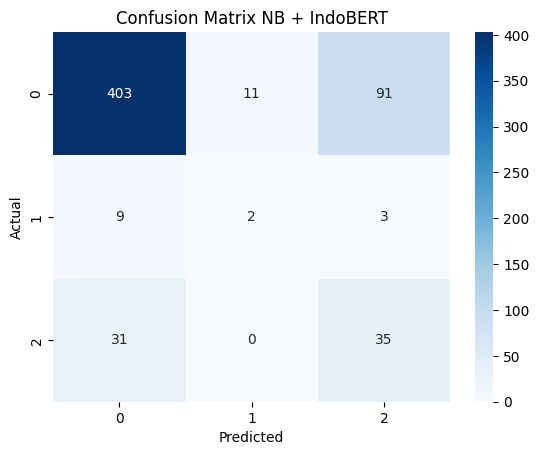

In [8]:
y_pred = nb.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['negatif','netral','positif']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix NB + IndoBERT")
plt.show()


In [9]:
import pickle
import os

os.makedirs("nb_indobert_pipeline", exist_ok=True)

pipeline = {
    'scaler': scaler,
    'pca': pca,
    'nb': nb,
    'label_map': label_map,
    'inv_label_map': inv_label_map
}

with open("nb_indobert_pipeline/pipeline_nb.pkl", "wb") as f:
    pickle.dump(pipeline, f)

tokenizer.save_pretrained("nb_indobert_pipeline/tokenizer")
bert_model.save_pretrained("nb_indobert_pipeline/bert_model")

"Pipeline saved!"


'Pipeline saved!'